# RL trainer

A class of trainer takes evnironment and agent as input. Make agent and environment interact between each other.

Gather training data from interaction and update agent accordingly.

In [1]:
import sys
sys.path.append('/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/codes/')
import warnings
warnings.filterwarnings("ignore")
from backtesting import *
from module.environment_new import *
from module.agent_network_new import *
import pandas as pd
import numpy as np
from tqdm import tqdm

## DQN agent

In [16]:
# hyper-parameter
np.random.seed(2021)
tf.random.set_seed(1234)
window_size = 4
year_start = 1997
year_end = 2017
year_range = np.arange(year_start, year_end+1)
training_idx_list = [np.arange(year, year + window_size, 1) for year in year_range[:-window_size]]
batch_size = 6
performance_df = pd.DataFrame()

# training
for training_years in training_idx_list:
    #training_years = training_idx_list[0]
    agent, history = training(training_years)

    # testing
    testing_period = np.append(training_years, training_years[-1] + 1)
    performance = testing(testing_period, agent)

    # store performance data
    performance_test = pd.DataFrame(performance)
    performance_df = pd.concat([performance_df, performance_test])


  2%|▏         | 18/1000 [00:08<08:39,  1.89it/s]

## Supporting function

In [6]:
def is_converge(data, threshold=0.05, window_size=5):
    converge = False
    i = len(data)
    mean_reward_current = np.mean(data[i-window_size:i])
    mean_reward_previous = np.mean(data[i-2*window_size:i-window_size])
    # print(mean_reward_current)
    # print(mean_reward_previous)
    if abs(mean_reward_current - mean_reward_previous) < threshold:
        print('Converged on episode {}'.format(i))
        converge = True
    return converge

## Training 

In [2]:
def training(year_range):
    # initialize environment and agent
    env = market_environment(year_range)
    ACTION_MAPPING = env.ACTION_MAPPING
    state_size = env.observation_space.shape[1] # given from environment
    action_size = len(ACTION_MAPPING)
    agent = DQNAgent(state_size, action_size)
    EPISODE_RANGE = 1000
    converge = False
    window_size = 50
    history = {'episode': [], "epsilon": [],'rewards': []}
    path = '../log/'
    model_name = 'DQN_'

    for e in tqdm(range(EPISODE_RANGE)):
        
        # initialize state
        state = env.reset()
        rewards = 0

        for time_window in year_range: # how many years in a training period

            # take an action
            action = agent.act(state) 
            
            # environment responds to the action and return new state and reward
            next_state, reward, done, info = env.step(ACTION_MAPPING[action])
            
            # record reward
            rewards += reward
            
            # record the experience for replay
            agent.memorize(state, action, reward, next_state, done) # record every trading 
            
            # transit to next state
            state = next_state

                # determine if the training is over or not
            if done:
                break

        # replay to train the network    
        if len(agent.memory) > batch_size: # batch_size = 2 to make agent learn for every 3 trading events
            agent.replay(batch_size)

        # log information
        history['episode'].append(e)
        history['epsilon'].append(agent.epsilon)
        history['rewards'].append(rewards)
        #history.append([e, agent.epsilon, rewards])

        # converge decision
        if e % window_size == 0 and e > window_size:
            converge = is_converge(history['rewards'], threshold=0.001, window_size=window_size)

        if converge:
            agent.save(path + model_name + str(year_range[-1] + 1))
            break
        
    return agent, history
    

In [7]:
training_years = training_idx_list[-1]
agent, history = training(training_years)

100%|██████████| 1000/1000 [09:25<00:00,  1.77it/s]


## Testing

In [13]:
def testing(testing_period, agent):
    # initialize environment and agent
    env = market_environment(testing_period)
    ACTION_MAPPING = env.ACTION_MAPPING
    agent.epsilon = 0
    performance = {'year':testing_period[-1],'action': [], 'reward': []}

    # initialize state
    state = env.reset()

    for _ in testing_period: # how many years in a training period

        # take an action
        action = agent.act(state) 
        
        # environment responds to the action and return new state and reward
        next_state, reward, done, info = env.step(ACTION_MAPPING[action])

        # transit to next state
        state = next_state

        # determine if the testing is over or not
        if done:
            performance['action'] = ACTION_MAPPING[action]
            performance['reward'] = reward
            break

    return performance

In [14]:
testing_period = np.append(training_idx_list[0], training_idx_list[0][-1] + 1)
performance = testing(testing_period, agent)

## Display

In [15]:
pd.DataFrame(performance)

,year,action,reward
0,2001,0.2,-0.35173


<function matplotlib.pyplot.show(close=None, block=None)>

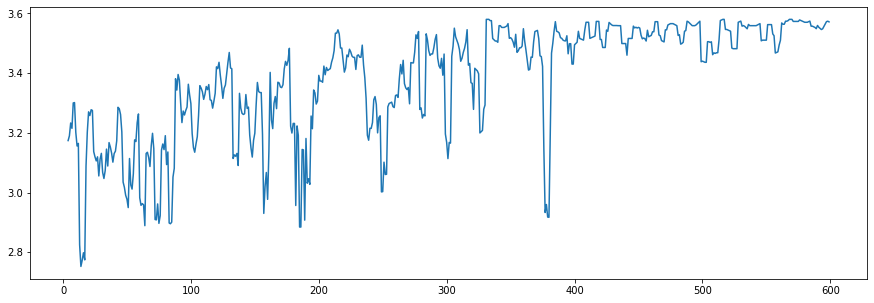

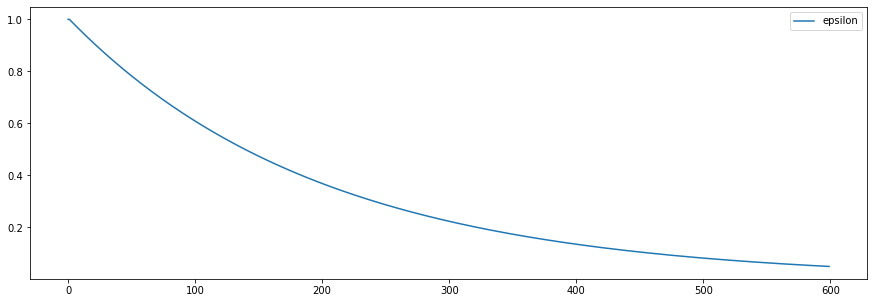

In [ ]:
df = pd.DataFrame(history, columns =["episode", "epsilon",'reward'])
df.set_index("episode")
df['reward'].rolling(5).mean().plot(figsize=(15,5))
plt.show

df[["epsilon"]].plot(figsize=(15,5))
plt.show